# Oxford: Smooth fit to log-odds ratios

In [1]:
import tqdm 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import json 
with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [3]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)

for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

In [4]:
data["year2"] = np.power(data["year"], 2) - 22
init["tau"] = init["sigma_sq"]
del init["sigma_sq"]

In [5]:
df = pd.DataFrame(data)

In [6]:
params["tau_a"] = 1e-3
params["tau_b"] = 1e-3

params["var"] = 1e6

params["mu_sd_proposal"] = 2.0
params["alpha_sd_proposal"] = .25
params["beta1_sd_proposal"] = 5e-2
params["beta2_sd_proposal"] = 7e-3
params["b_sd_proposal"] = 2.0

In [7]:
init["mu"][0] = np.mean(df.r0/df.n0)
init["alpha"][0] = np.mean(df.r1/df.n1)

In [8]:
df["r_sum"] = df.r0 + df.r1
df["n_sum"] = df.n0 + df.n1
df["nr_sum_diff"] = df.n_sum - df.r_sum
df["n1r1_diff"] = df.n1 - df.r1

In [9]:
def sampler(nchain, data, init, params):
    
    # initialisation de la chaîne
    # acceptance rates are stored in history
    chain = dict()
    history = dict()
    for param_name, param_init in init.items():
        chain[param_name] = np.zeros((nchain+1, param_init.shape[0]))
        chain[param_name][0, :] = param_init
        
        history[param_name] = np.zeros(param_init.shape[0])
        
    # définition des hyper-paramètres
    K = int(params["K"])
    
    tau_a = params["tau_a"]
    tau_b = params["tau_b"]
    
    var = params["var"]
    
    mu_sd_proposal = params["mu_sd_proposal"]
    alpha_sd_proposal = params["alpha_sd_proposal"]
    beta1_sd_proposal = params["beta1_sd_proposal"]
    beta2_sd_proposal = params["beta2_sd_proposal"]
    b_sd_proposal = params["b_sd_proposal"]
    
    for i in tqdm.tqdm(range(1, nchain+1)):
        ## mise à jour de mu 
        mu_current = chain["mu"][i-1, :]
        alpha_current = chain["alpha"][i-1, :]
        beta1_current = chain["beta1"][i-1, :]
        beta2_current = chain["beta2"][i-1, :]
        b_current = chain["b"][i-1, :]
        
        logpsi_current = alpha_current + beta1_current * data.year + beta2_current*data.year2 + b_current
    
        mu_proposal = mu_current + np.random.normal(scale=mu_sd_proposal, size=K)
        
        mu_top = - mu_proposal / (2*var) - data.nr_sum_diff * mu_proposal
        mu_top = mu_top - data.n0 * np.log1p(np.exp(-mu_proposal))
        mu_top = mu_top - data.n1 * np.log1p(np.exp(-mu_proposal -logpsi_current))
        
        mu_bottom = - mu_current / (2*var) - data.nr_sum_diff * mu_current
        mu_bottom = mu_bottom - data.n0 * np.log1p(np.exp(-mu_current))
        mu_bottom = mu_bottom - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        mu_acceptance = np.exp(mu_top - mu_bottom)
        
        mu_accept_mask = (mu_acceptance > np.random.rand())
        mu_current[mu_accept_mask] = mu_proposal[mu_accept_mask]
        
        history["mu"] =  history["mu"] + mu_accept_mask
        chain["mu"][i, :] = mu_current
        
        ## mise à jour de alpha
        alpha_proposal = alpha_current + np.random.normal(scale=alpha_sd_proposal)
        logpsi_proposal = logpsi_current + (alpha_proposal - alpha_current)
        
        alpha_top = - np.power(alpha_proposal, 2) / (2*var)
        alpha_top = alpha_top - np.sum(logpsi_proposal * data.n1r1_diff)
        alpha_top = alpha_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        alpha_bottom = - np.power(alpha_current, 2) / (2*var) 
        alpha_bottom = alpha_bottom - np.sum(logpsi_current * data.n1r1_diff)
        alpha_bottom = alpha_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        alpha_acceptance = np.exp(alpha_top - alpha_bottom)
        if alpha_acceptance > np.random.rand():
            chain["alpha"][i, :] = alpha_proposal
            alpha_current = alpha_proposal
            logpsi_current = logpsi_proposal
            history["alpha"] += 1
        else:
            chain["alpha"][i, :] = alpha_current
        
        ## mise à jour de beta1
        beta1_proposal = beta1_current + np.random.normal(scale=beta1_sd_proposal)
        logpsi_proposal = logpsi_current + (beta1_proposal - beta1_current)* data.year
        
        beta1_top = - np.power(beta1_proposal, 2) / (2*var)
        beta1_top = beta1_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta1_top = beta1_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta1_bottom = - np.power(beta1_current, 2) / (2*var)
        beta1_bottom = beta1_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta1_bottom = beta1_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta1_acceptance = np.exp(beta1_top - beta1_bottom)
        if beta1_acceptance > np.random.rand():
            chain["beta1"][i, :] = beta1_proposal
            beta1_current = beta1_proposal
            logpsi_current = logpsi_proposal
            history["beta1"] += 1
        else:
            chain["beta1"][i, :] = beta1_current
        
        ## mise à jour de beta2
        beta2_proposal = beta2_current + np.random.normal(scale=beta2_sd_proposal)
        logpsi_proposal = logpsi_current + (beta2_proposal - beta2_current) * data.year2
        
        beta2_top = - np.power(beta2_proposal, 2) / (2*var)
        beta2_top = beta2_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta2_top = beta2_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta2_bottom = - np.power(beta2_current, 2) / (2*var)
        beta2_bottom = beta2_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta2_bottom = beta2_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta2_acceptance = np.exp(beta2_top - beta2_bottom)
        if beta2_acceptance > np.random.rand():
            chain["beta2"][i, :] = beta2_proposal
            beta2_current = beta2_proposal
            logpsi_current = logpsi_proposal
            history["beta2"] += 1
        else:
            chain["beta2"][i, :] = beta2_current
        
        ## mise à jour de b
        tau_current = chain["tau"][i-1,:]
        b_proposal = b_current + np.random.normal(scale=b_sd_proposal, size=K)
        logpsi_proposal = logpsi_current + (b_proposal - b_current)
        
        b_top = - (tau_current / 2) * np.power(b_proposal, 2)
        b_top = b_top - logpsi_proposal * data.n1r1_diff
        b_top = b_top - data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal))
        
        b_bottom = - (tau_current / 2) * np.power(b_current, 2)
        b_bottom = b_bottom - logpsi_current * data.n1r1_diff
        b_bottom = b_bottom - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        b_acceptance = np.exp(b_top - b_bottom)
        b_accept_mask = (b_acceptance > np.random.rand())
        b_current[b_accept_mask] = b_proposal[b_accept_mask]
        logpsi_current[b_accept_mask] = logpsi_proposal[b_accept_mask]
        
        history["b"] = history["b"] + b_accept_mask
        chain["b"][i, :] = b_current
        
        ## mise à jour de tau
        tau_proposal = np.random.gamma(1/(tau_b+np.sum(np.power(b_current,2))/2), tau_a + K/2)
        chain["tau"][i, :] = tau_proposal
        history["tau"] += 1
        
    for param_name, param_history in history.items():
        history[param_name] = param_history / nchain
    
    return chain, history

In [10]:
chain, history = sampler(10000, df, init, params)

  6%|██████▉                                                                                                     | 643/10000 [00:06<01:27, 107.21it/s]/home/meh/anaconda3/envs/minimal/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.83it/s]


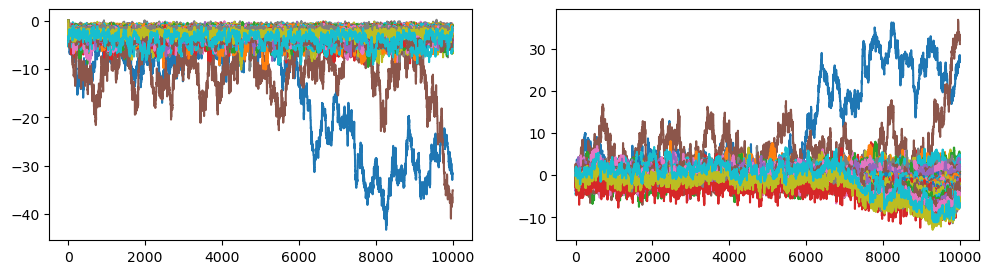

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(chain["mu"])
axs[1].plot(chain["b"])
plt.show()

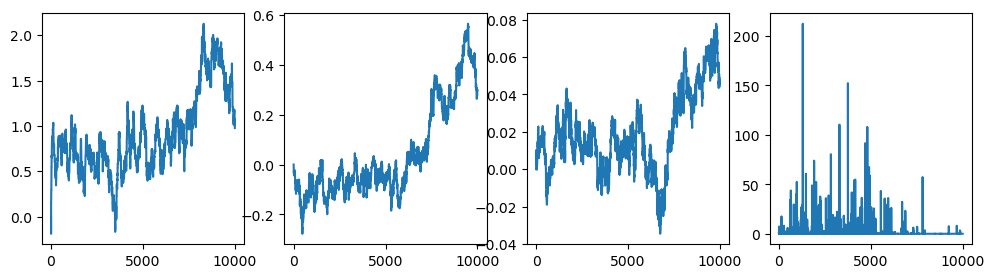

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].plot(chain["alpha"])
axs[1].plot(chain["beta1"])
axs[2].plot(chain["beta2"])
axs[3].plot(chain["tau"])
plt.show()

In [13]:
history

{'alpha': array([0.1833]),
 'beta1': array([0.2223]),
 'beta2': array([0.2834]),
 'mu': 0      0.3586
 1      0.2654
 2      0.3093
 3      0.2424
 4      0.2225
         ...  
 115    0.2498
 116    0.2044
 117    0.2055
 118    0.2462
 119    0.2447
 Length: 120, dtype: float64,
 'b': 0      0.3637
 1      0.3043
 2      0.4144
 3      0.2619
 4      0.2616
         ...  
 115    0.2903
 116    0.2476
 117    0.2585
 118    0.3518
 119    0.2685
 Length: 120, dtype: float64,
 'tau': array([1.])}